In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
datatrain = pd.read_csv(r'D:\GitHubProject\SRTP-program-of-SEU---meteorological-forecasting\maxtempe\Train.csv',engine = 'python')
datatest = pd.read_csv(r'D:\GitHubProject\SRTP-program-of-SEU---meteorological-forecasting\maxtempe\Test.csv',engine = 'python')
datapredict = pd.read_csv(r'D:\GitHubProject\SRTP-program-of-SEU---meteorological-forecasting\maxtempe\result_AR.csv',engine = 'python')


traindataset = datatrain['DailyMaximumDryBulbTemperature'].values
testdataset = datatest['DailyMaximumDryBulbTemperature'].values
resultdataset = datapredict['0'].values

# 转为len*1列的数组
traindataset = traindataset.reshape(-1,1)
traindataset = traindataset.astype('float32')
testdataset = testdataset.reshape(-1,1)
testdataset = testdataset.astype('float32')
resultdataset = resultdataset.reshape(-1,1)
resultdataset = resultdataset.astype('float32')

dataset = np.vstack((traindataset,testdataset));
lossdataset =  dataset - resultdataset

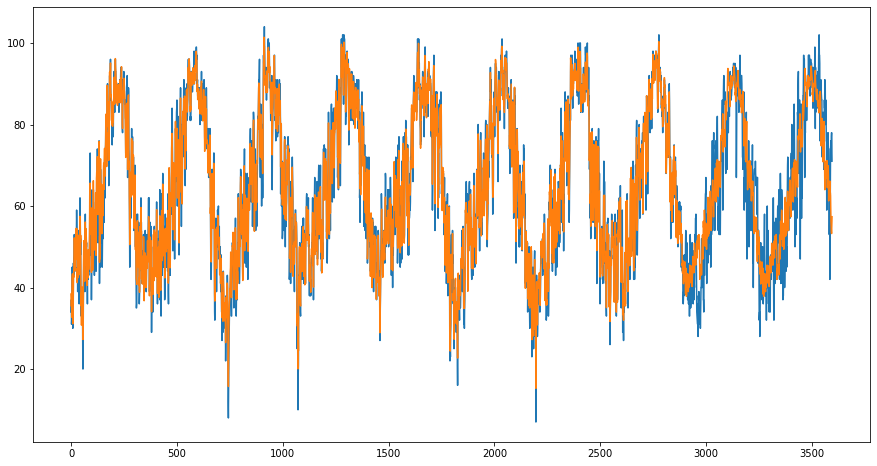

In [5]:
## 实际值和预测值
plt.figure(figsize = (15,8))
plt.plot(dataset)
plt.plot(resultdataset)

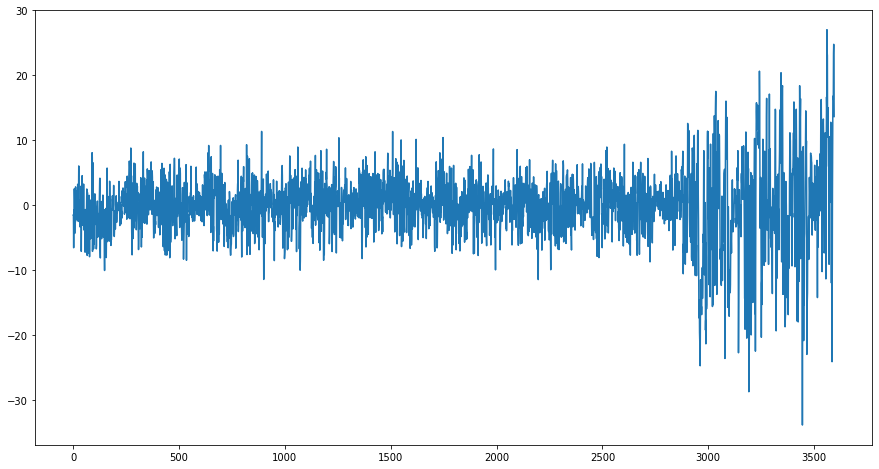

In [6]:
# 残差图
plt.figure(figsize = (15,8))
plt.plot(lossdataset)

In [7]:
# 数据预处理
# dateset为数据，look_back为以几行数据为特征数目
# 即预测第 i 天数据时，以第 i-look_back 到 i-1天的数据作为参考
def creat_dataset(ds, look_back=1):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back):
        a = ds[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(ds[i+look_back,0])
    return np.array(dataX),np.array(dataY)

In [8]:
losstraindataset = lossdataset[:len(traindataset)]
losstestdataset = lossdataset[len(traindataset):]

In [9]:
# 将数据归 1 化
scaler  = MinMaxScaler(feature_range = (0, 1))
scaler.fit(lossdataset)
losstraindataset = scaler.transform(losstraindataset)
losstestdataset = scaler.transform(losstestdataset)
lossdataset = scaler.transform(lossdataset)

train = losstraindataset.copy()
test = losstestdataset.copy()

look_back = 6
trainX, trainY = creat_dataset(train,look_back)
testX, testY = creat_dataset(test,look_back)
trainX.shape,testX.shape

((2870, 6), (714, 6))

In [10]:
# LSTM要求输入是3维的
# 第二维是 timesteps，第三维是 features
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))
trainX.shape,testX.shape

((2870, 1, 6), (714, 1, 6))

In [11]:
# 创建 LSTM Model
# 可以在 youtube 搜 keras+lstm，或者看 Jason Brownlee 的博客详细了解
model = Sequential()
# input_shape 两个参数对应 timesteps 和 features 数
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# 实测训练 10 次取得较好的预测结果
model.fit(trainX,trainY,epochs=200,batch_size=8,verbose=0)
# 对训练集和测试集分别进行预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# 逆变换得真实值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(np.array(trainY.reshape(-1,1)))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(np.array(testY.reshape(-1,1)))
lossdataset = scaler.inverse_transform(np.array(lossdataset.reshape(-1,1)))
test = scaler.inverse_transform(np.array(test.reshape(-1,1)))
train = scaler.inverse_transform(np.array(train.reshape(-1,1)))

# 误差分析
trainScore = mean_squared_error(trainY,trainPredict)
print('Train Score: %.2f MSE' % trainScore)
testScore = mean_squared_error(testY,testPredict)
print('Test Score: %.2f MSE' % testScore)

Train Score: 8.89 MSE
Test Score: 55.45 MSE


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 176       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


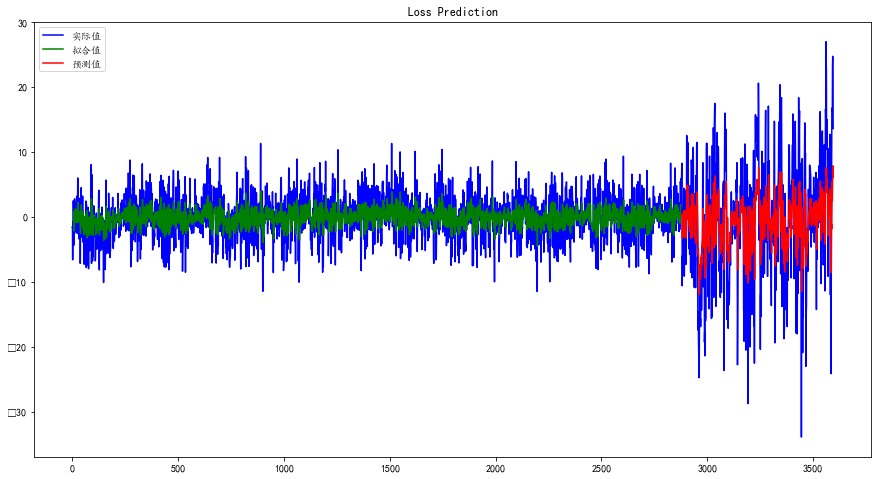

In [14]:
# 拷贝数据，注意每组数据前 look_back 天作为输入，无法预测，值设为 nan
trainPredictPlot = np.empty_like(lossdataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict

testPredictPlot = np.empty_like(lossdataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+look_back*2:len(lossdataset)] = testPredict

# 绘图
plt.rcParams['font.sans-serif'] = 'KaiTi'
plt.figure(figsize=(15,8))
plt.title('Loss Prediction')
plt.plot(lossdataset,color ='blue',label='实际值')
plt.plot(trainPredictPlot,color ='green',label='拟合值')
plt.plot(testPredictPlot,color ='red',label='预测值')
plt.legend(loc='best')

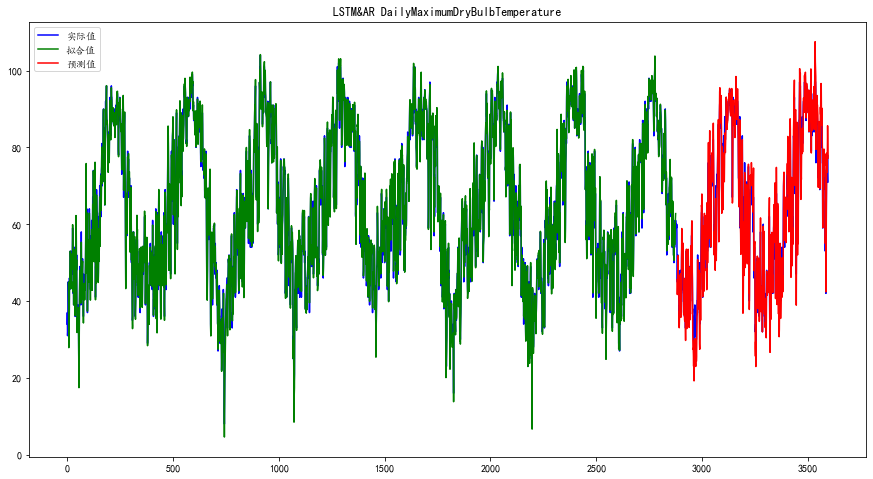

In [15]:
trainPredictPlot = np.empty_like(lossdataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict + traindataset[look_back:]

testPredictPlot = np.empty_like(lossdataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+look_back*2:len(lossdataset)] = testPredict + testdataset[look_back:]

# 绘图
plt.rcParams['font.sans-serif'] = 'KaiTi'
plt.figure(figsize=(15,8))
plt.title('LSTM&AR DailyMaximumDryBulbTemperature')
plt.plot(dataset,color ='blue',label='实际值')
plt.plot(trainPredictPlot,color ='green',label='拟合值')
plt.plot(testPredictPlot,color ='red',label='预测值')
plt.legend(loc='best')

In [16]:
trainPredict.shape,train.shape

((2870, 1), (2876, 1))

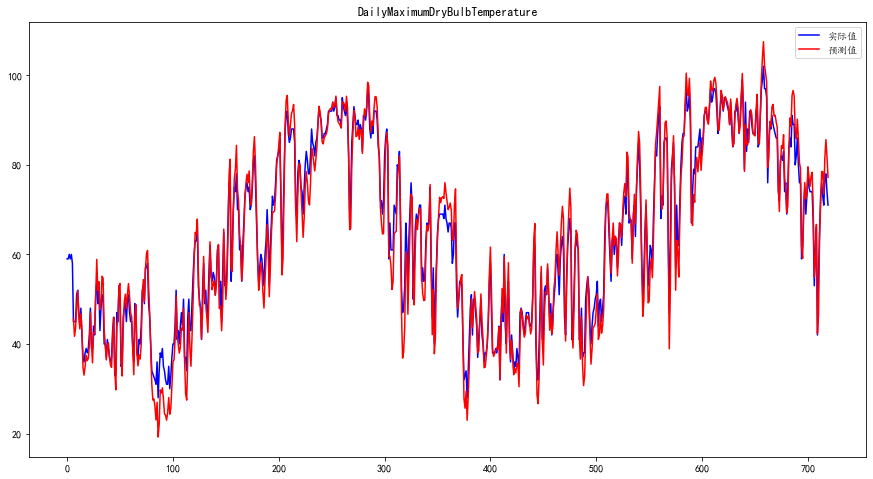

In [17]:
trainPlot = np.empty_like(train)
trainPlot [:] = np.nan
trainPlot [look_back:len(train)] = trainPredict + traindataset[look_back:]

testPlot = np.empty_like(test)
testPlot [:] = np.nan
testPlot [look_back:len(test)] = testPredict + testdataset[look_back:]

plt.figure(figsize=(15,8))
plt.title('DailyMaximumDryBulbTemperature')
plt.plot(testdataset,color ='blue',label='实际值')
plt.plot(testPlot,color ='red',label='预测值')
plt.legend(loc='best')

In [18]:
testScore = mean_squared_error(testPlot[look_back:],testdataset[look_back:])
print('Test Score: %.2f MSE' % testScore)
# 5 11.40
# 6 12.69

Test Score: 12.69 MSE


In [20]:
resultCsv = np.vstack((trainPlot,testPlot))
pd.DataFrame(resultCsv).to_csv('D:\\GitHubProject\\SRTP-program-of-SEU---meteorological-forecasting\\maxtempe\\result_LSTM&AR.csv',index = False)